## E1 - Label Noise

I implemented 2LR Plugin-Approach (Bobs Paper) and analyse how label noise affects the tradeoff between Fairness and Performance

Fairness Metric: Mean Distance
Performance Metric: Balanced Error

In [2]:

from random import seed, shuffle
from tqdm import tqdm
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools') # so i can import tools
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
#Configuration to make plots nicer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
np.linspace(1.0,1.1,21)

array([1.   , 1.005, 1.01 , 1.015, 1.02 , 1.025, 1.03 , 1.035, 1.04 ,
       1.045, 1.05 , 1.055, 1.06 , 1.065, 1.07 , 1.075, 1.08 , 1.085,
       1.09 , 1.095, 1.1  ])

 95%|█████████▌| 20/21 [00:41<00:02,  2.04s/it]/tmp/ipykernel_57768/3251969083.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,4))
100%|██████████| 21/21 [00:43<00:00,  2.09s/it]


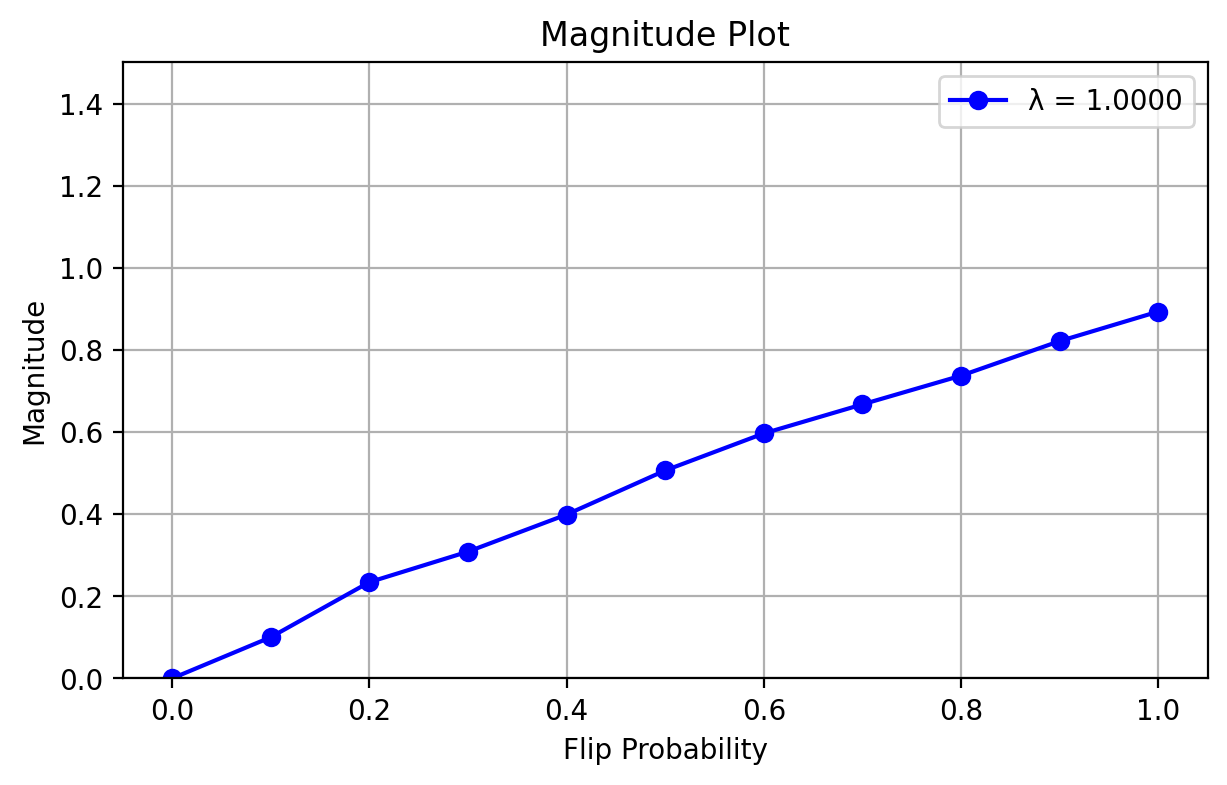

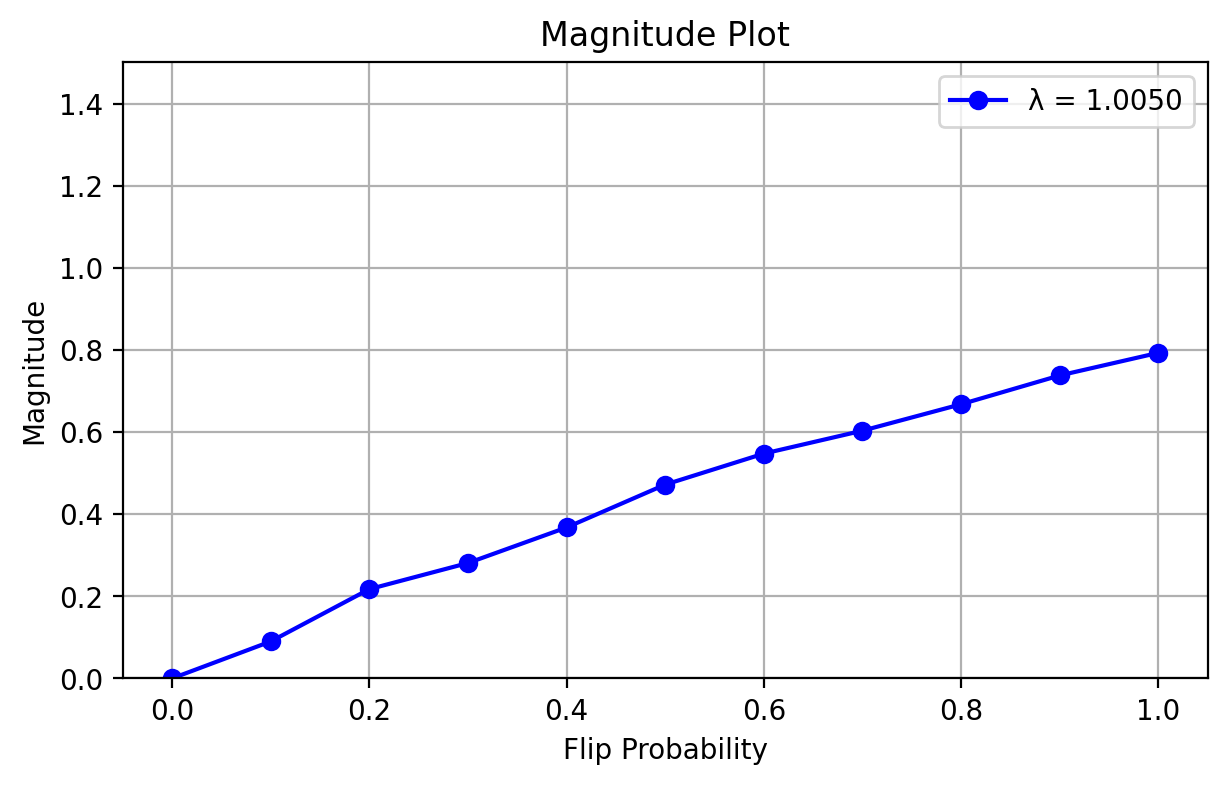

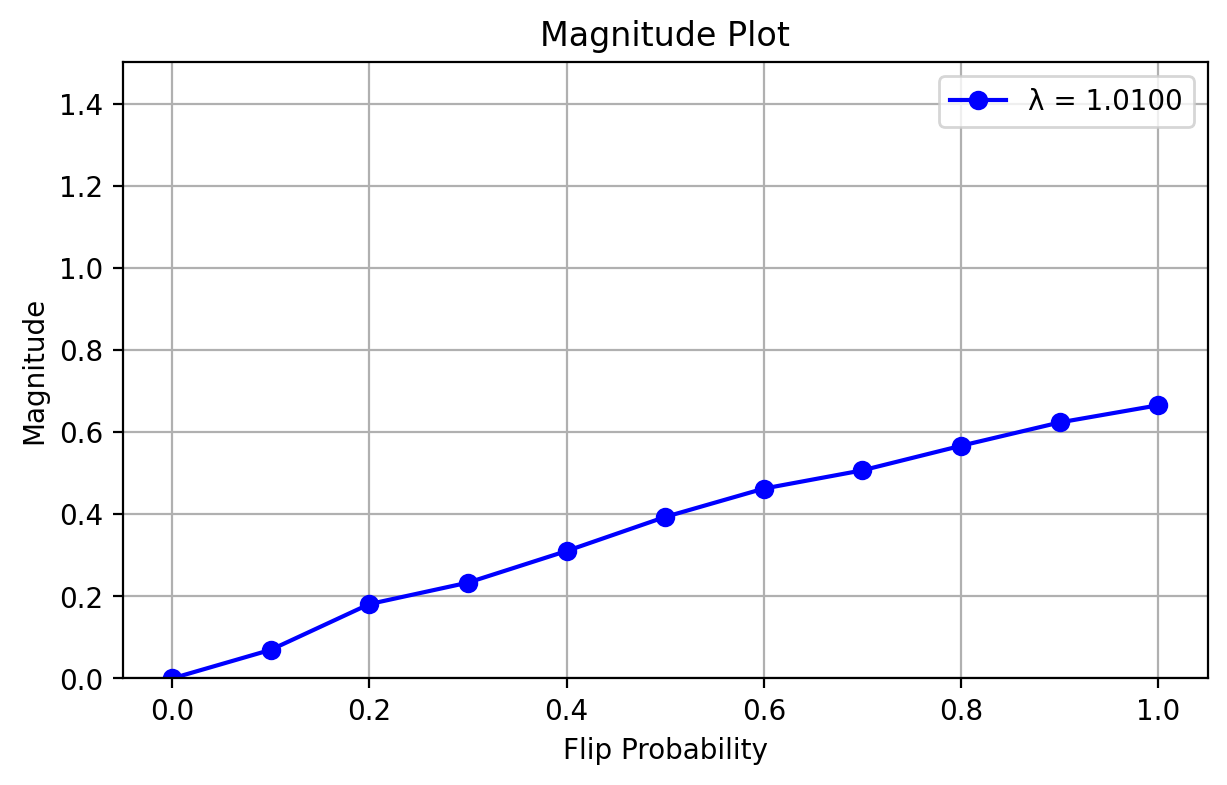

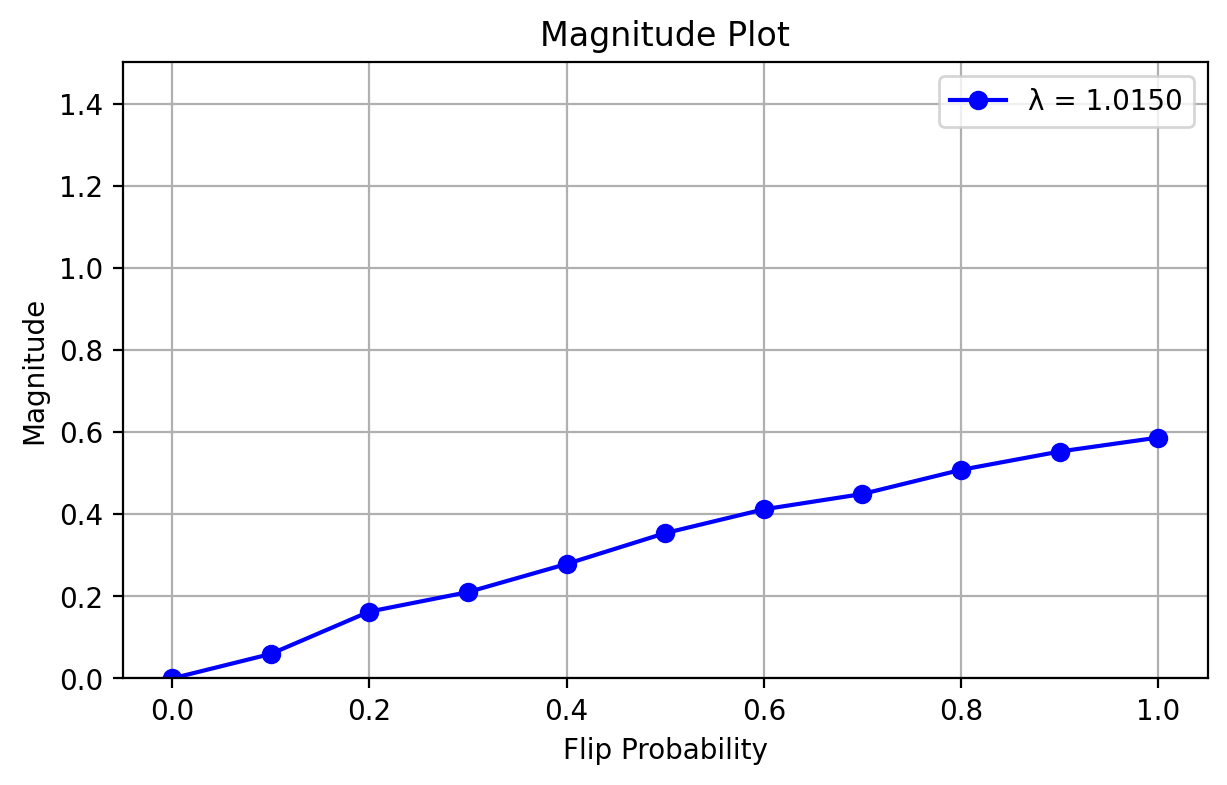

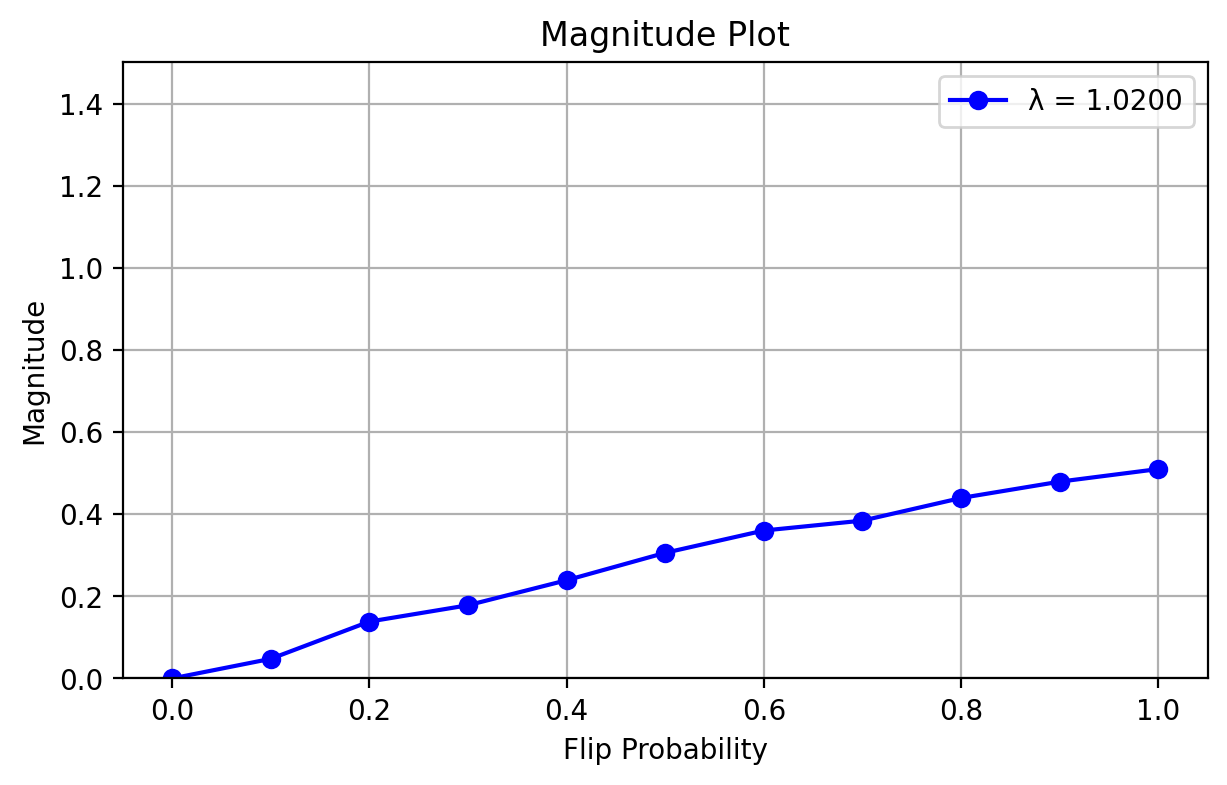

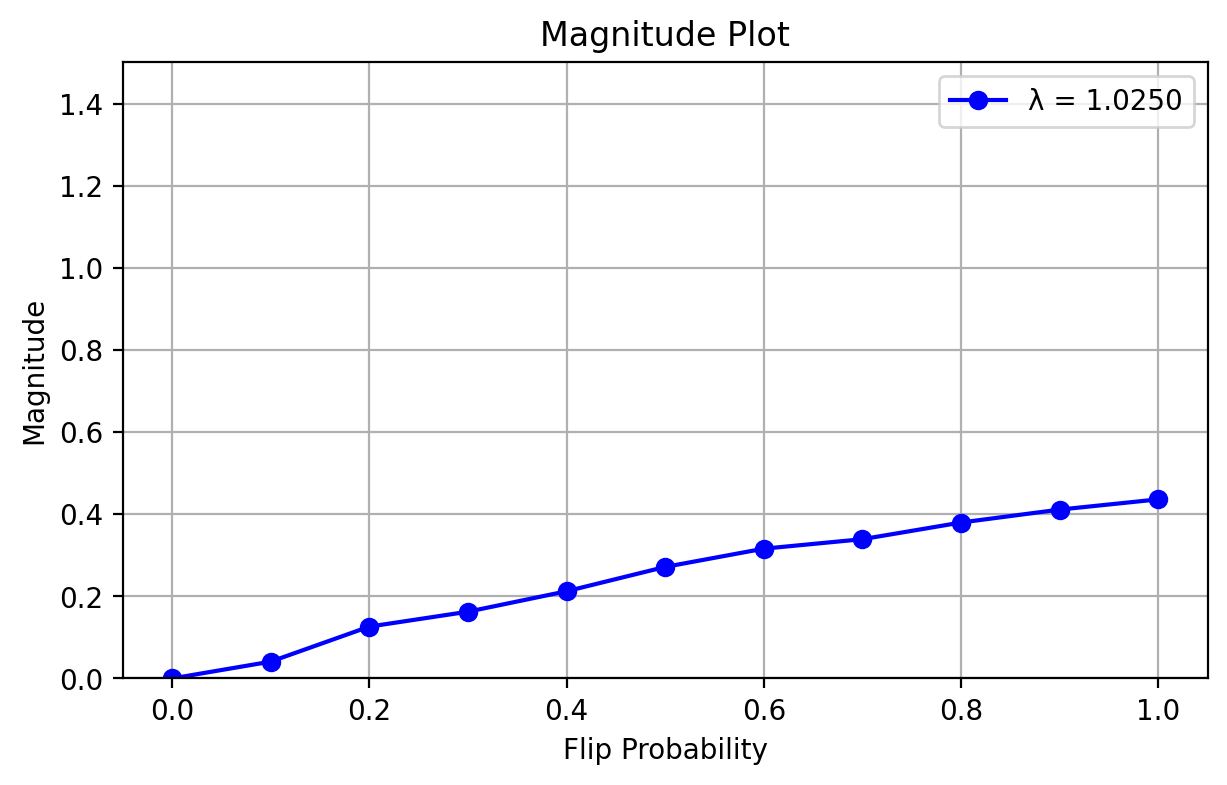

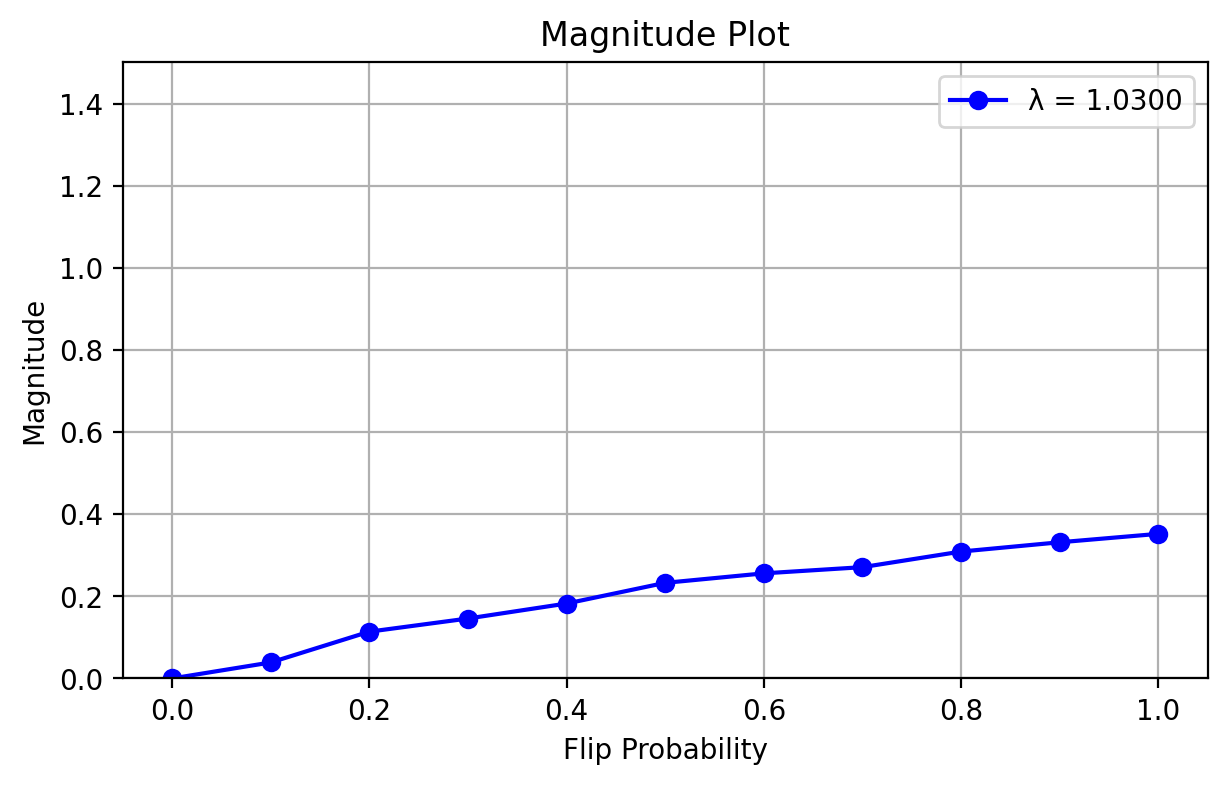

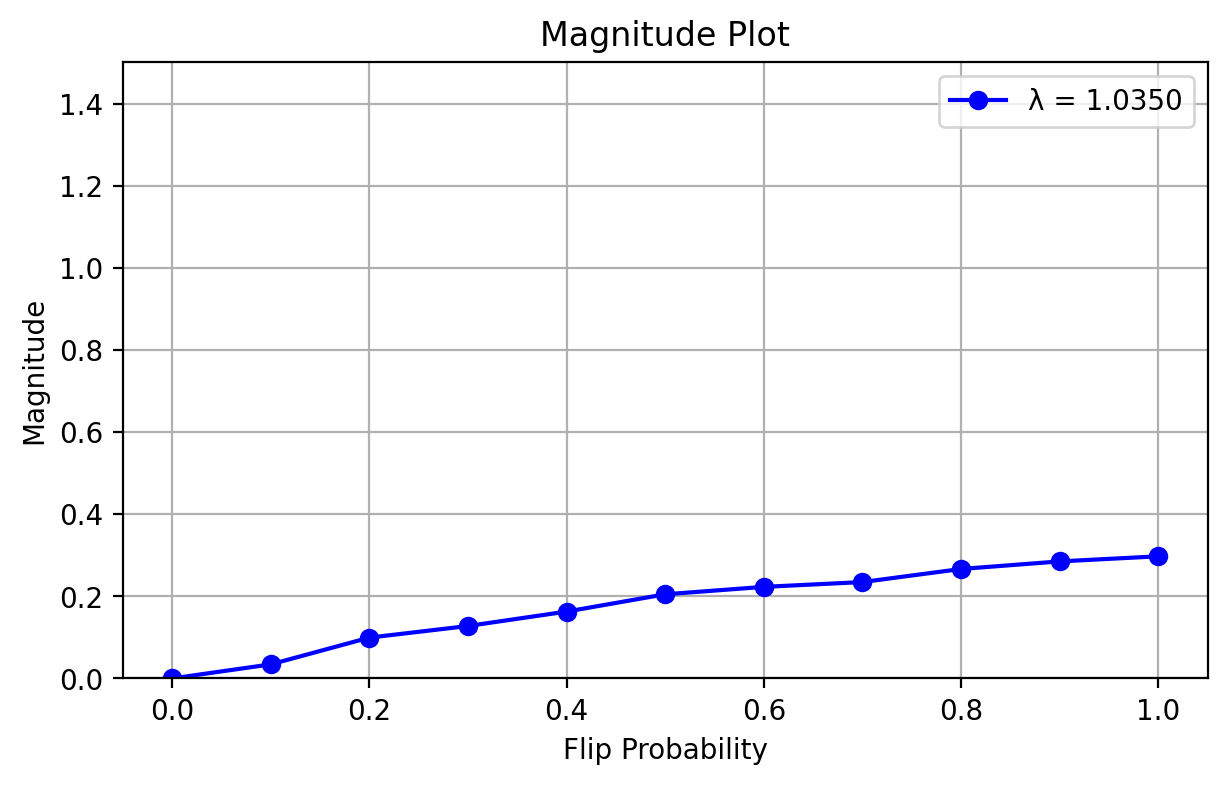

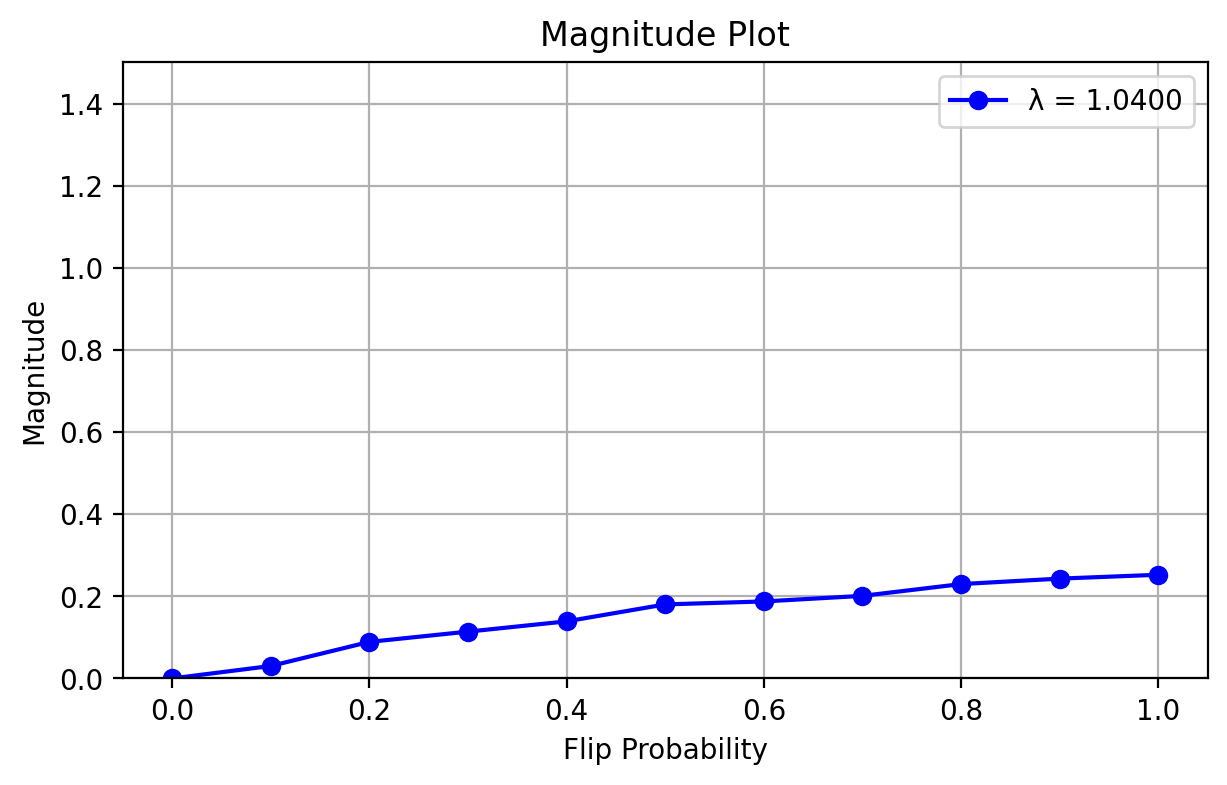

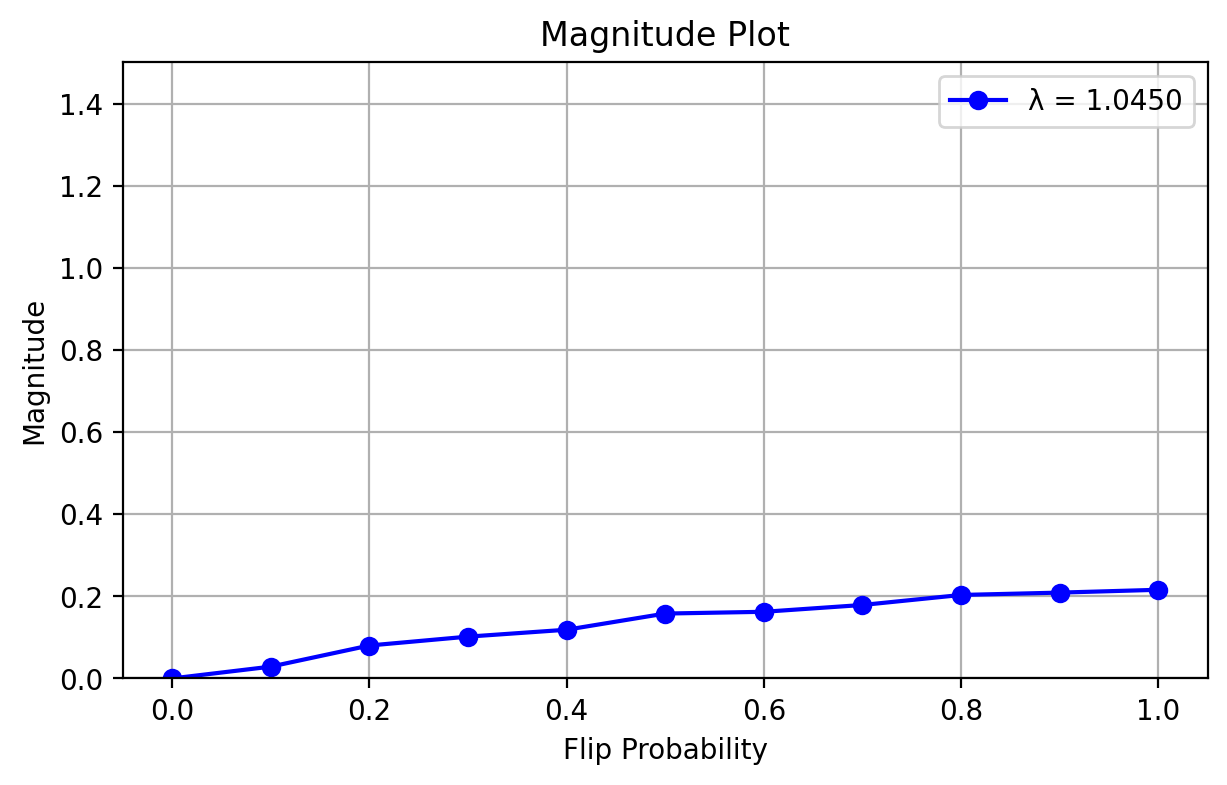

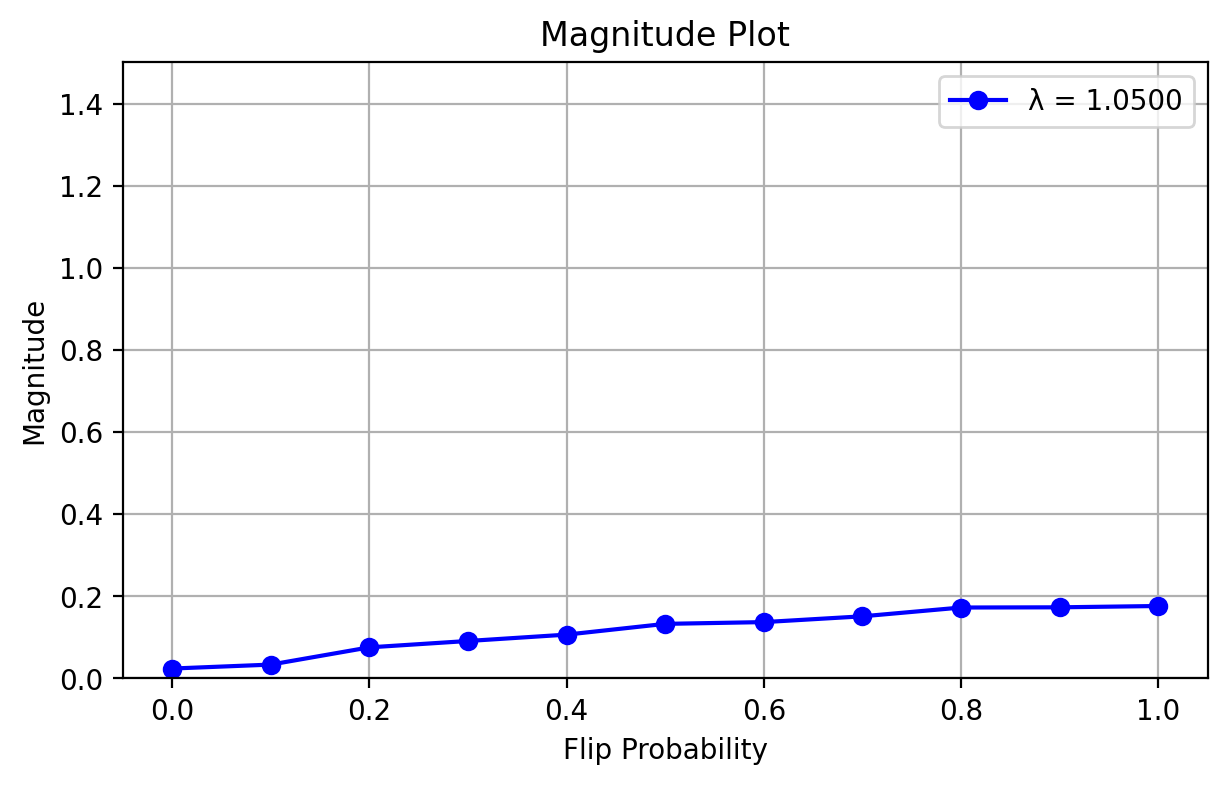

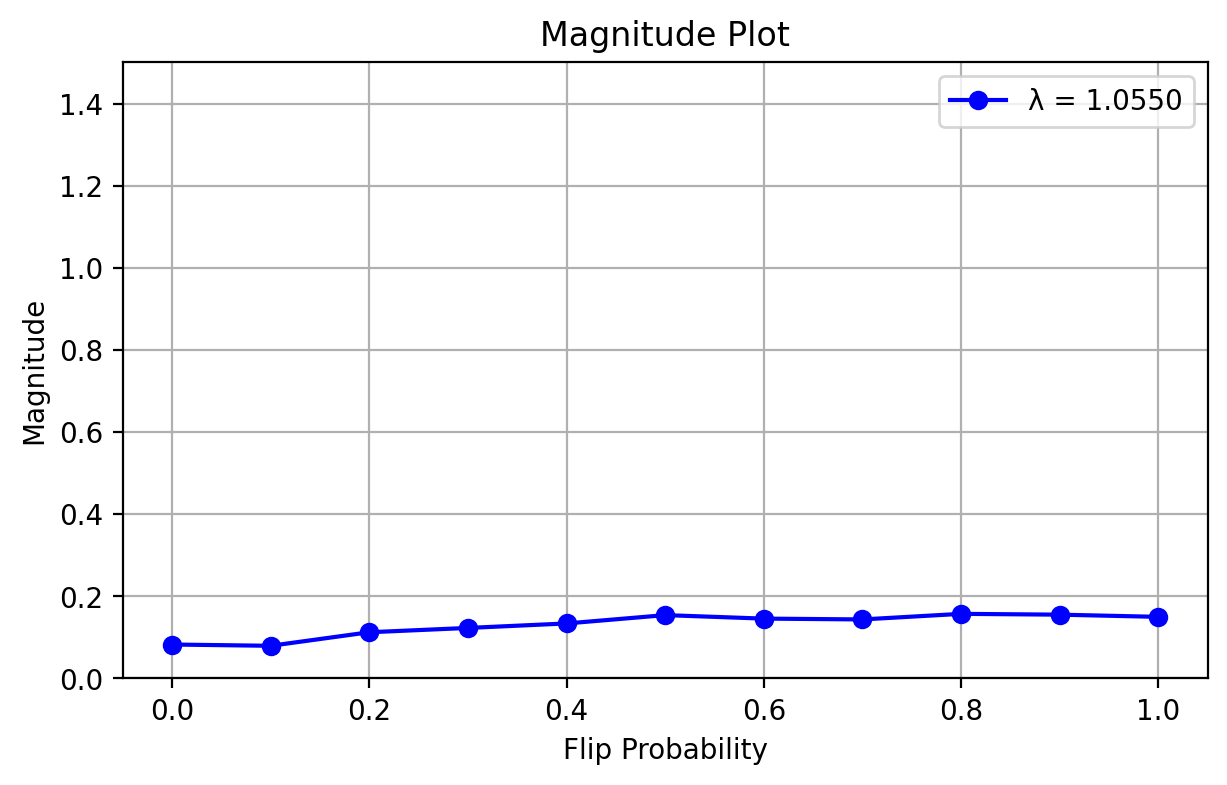

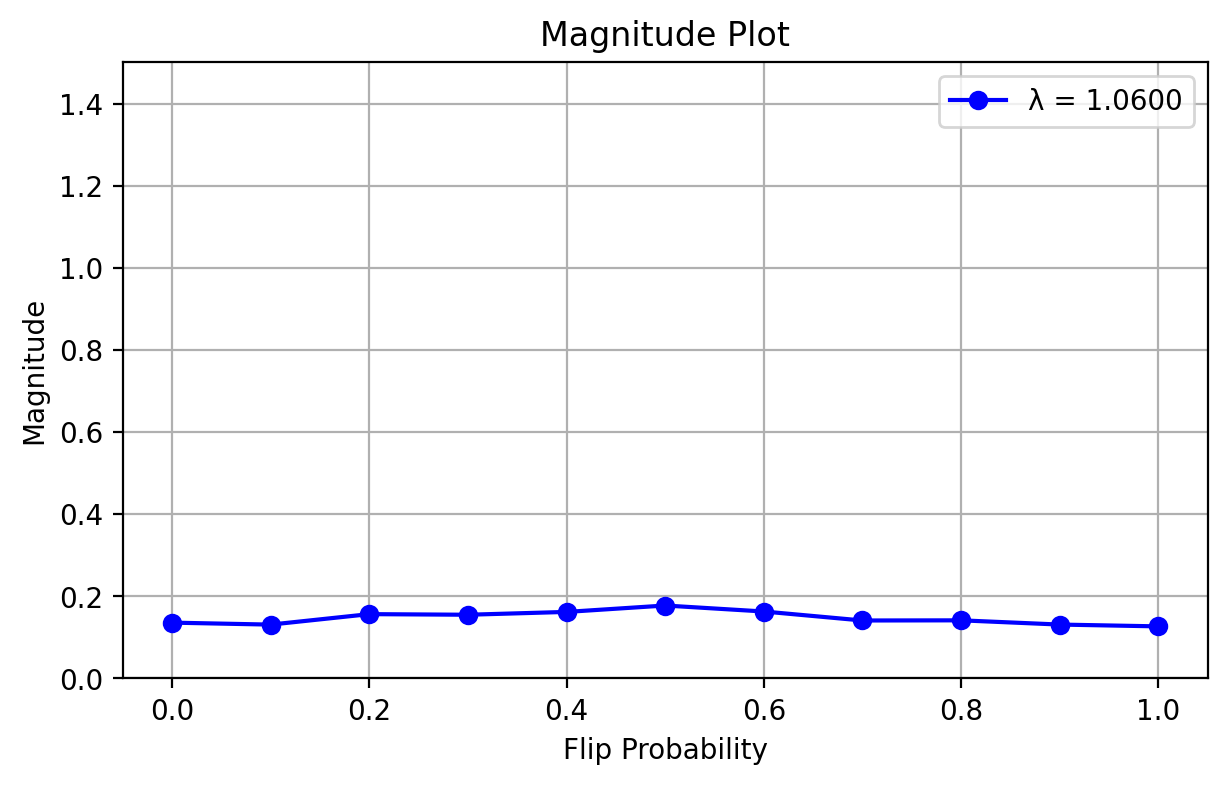

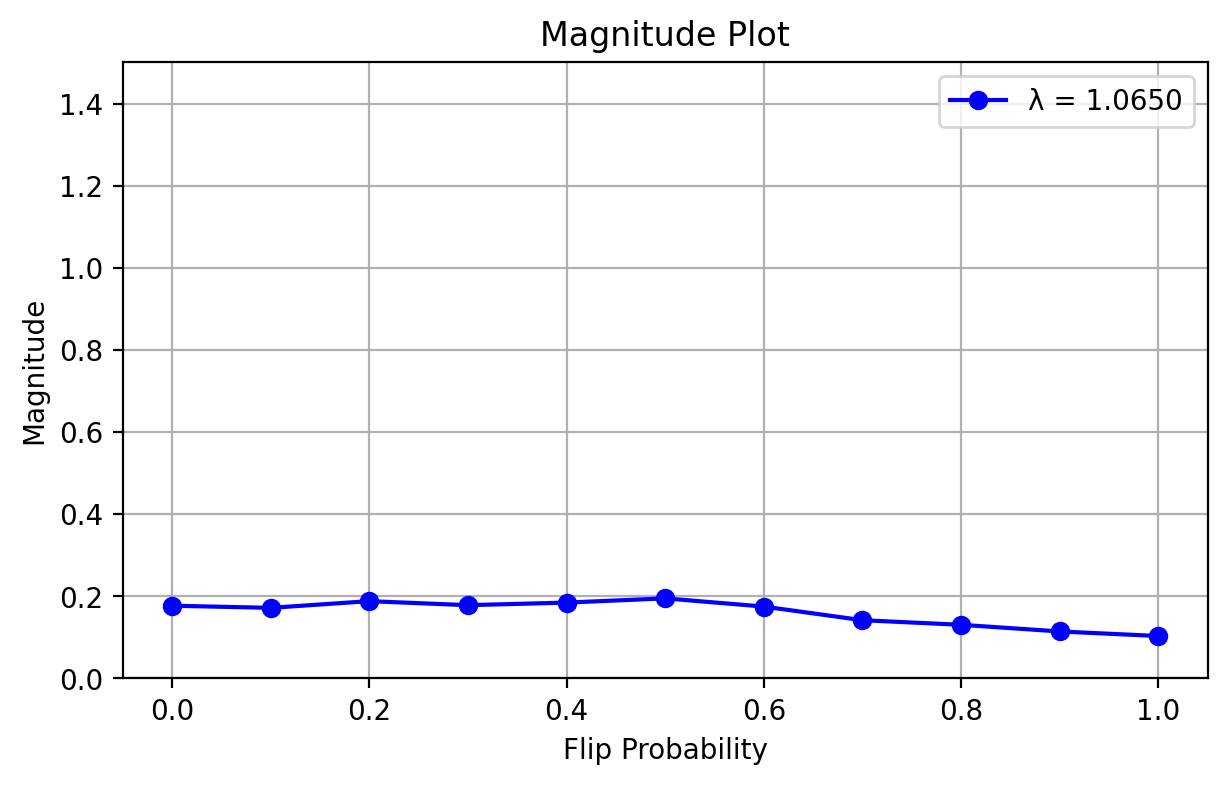

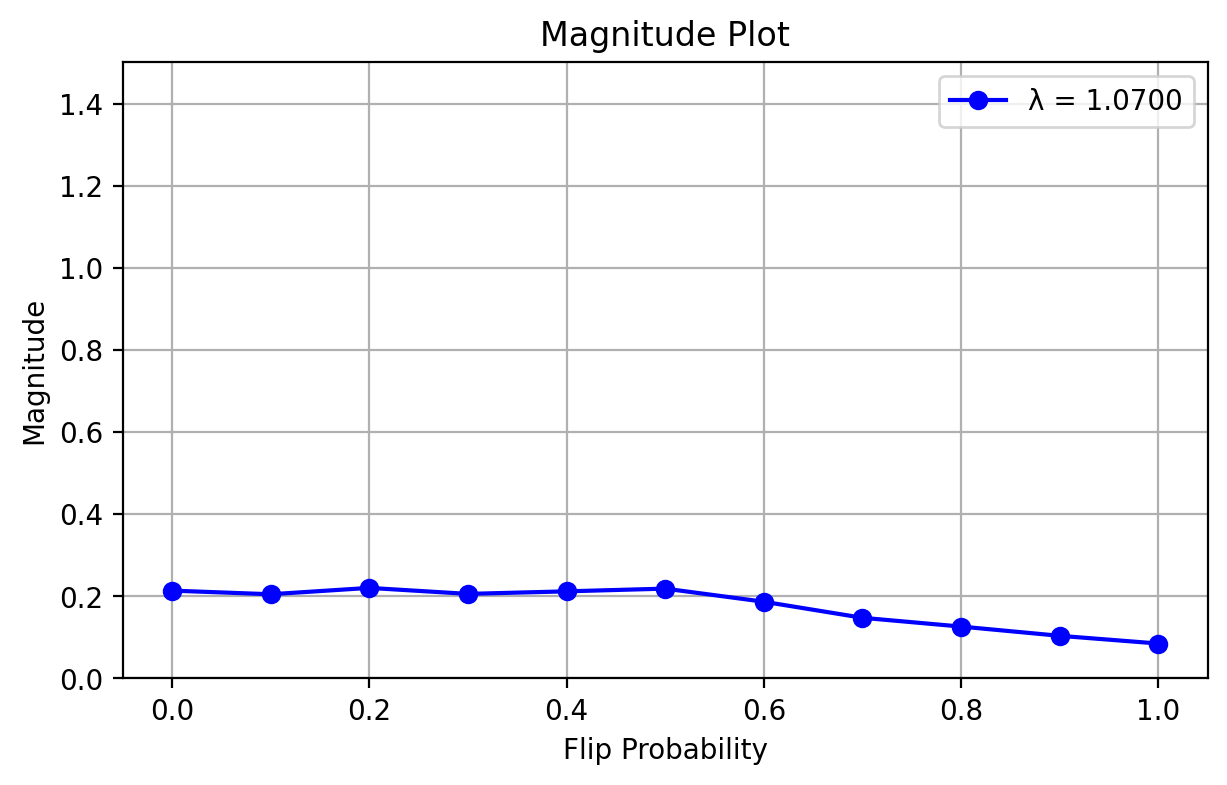

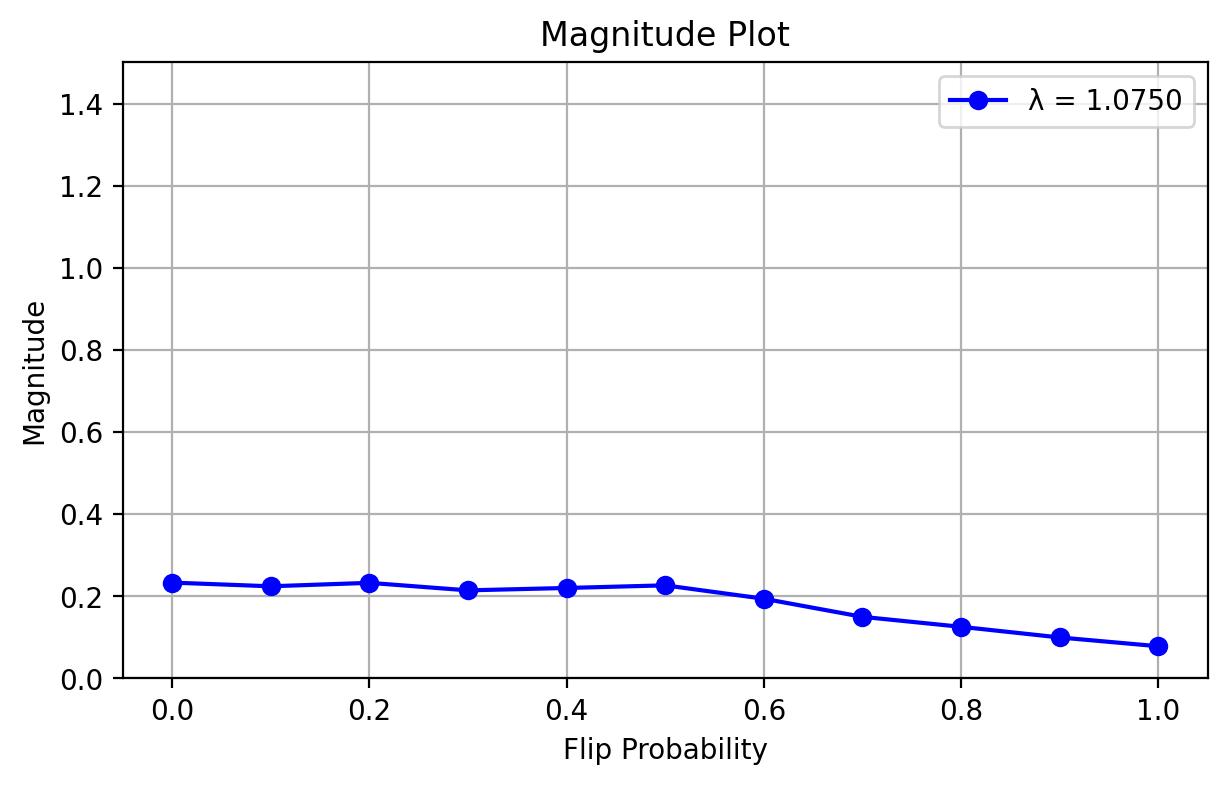

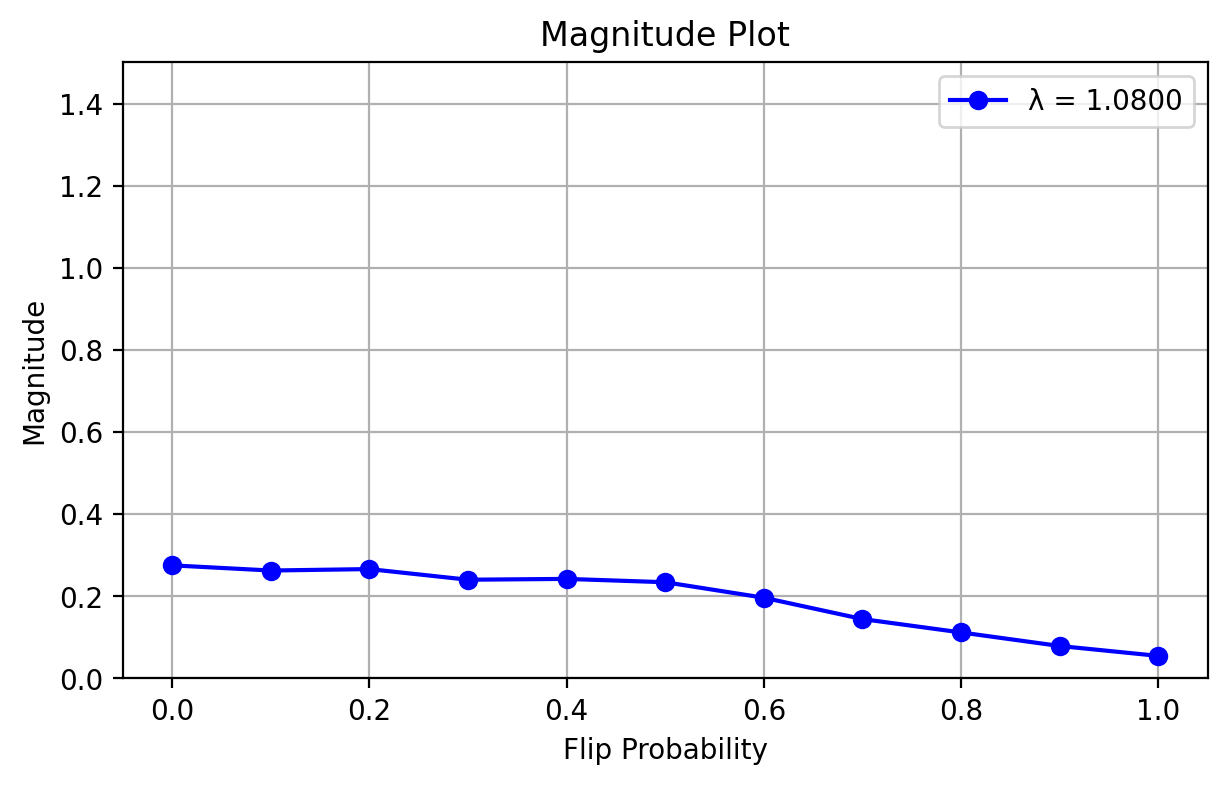

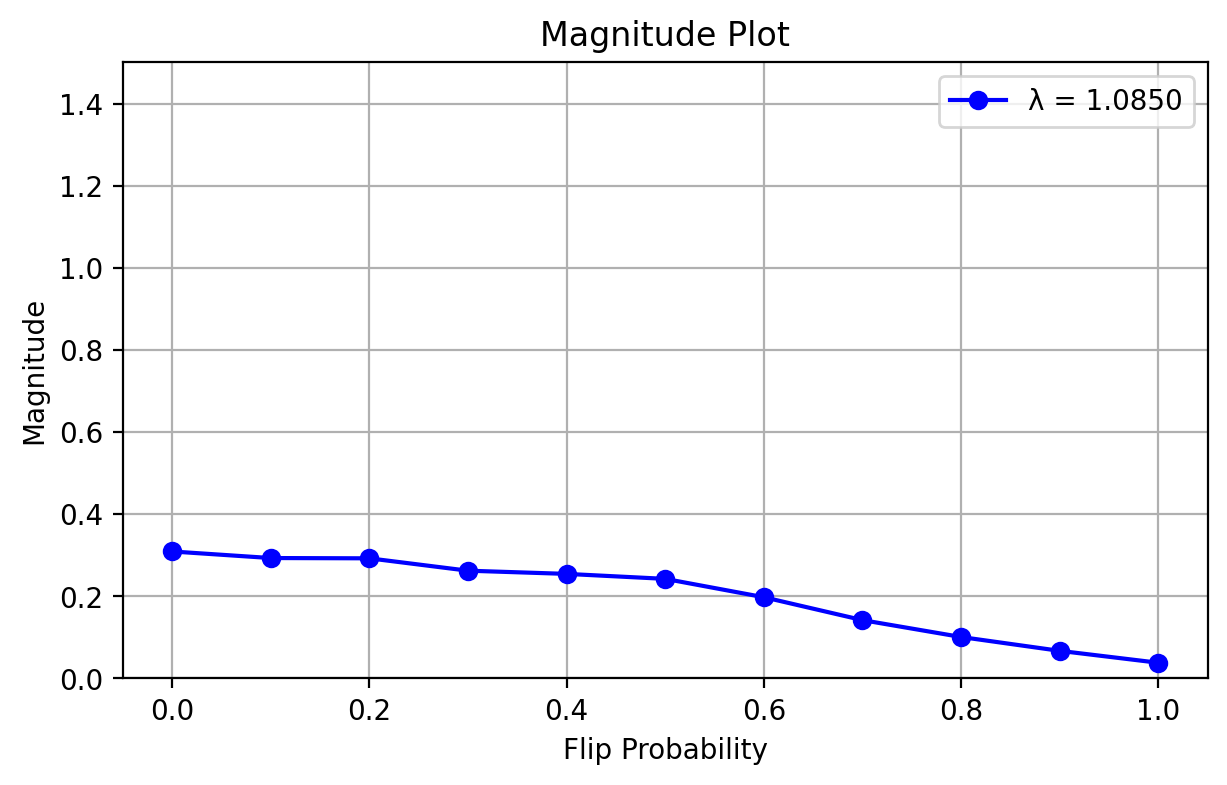

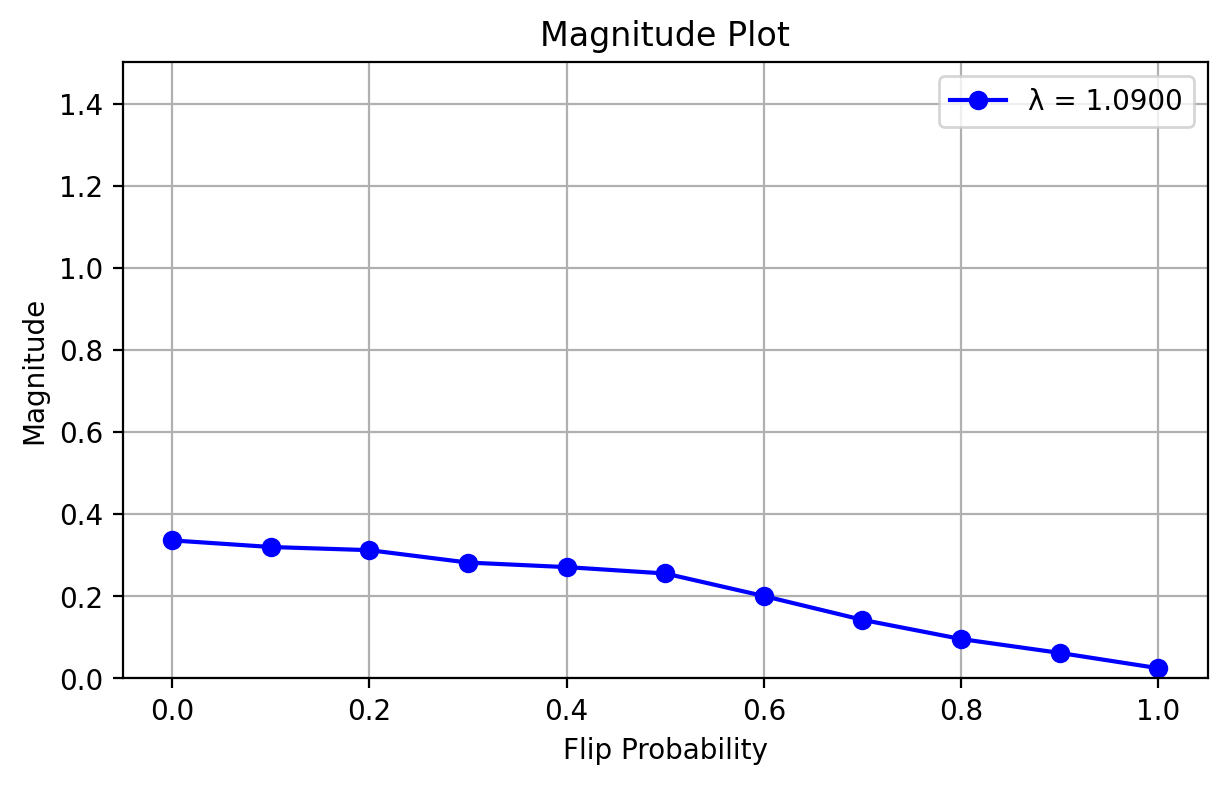

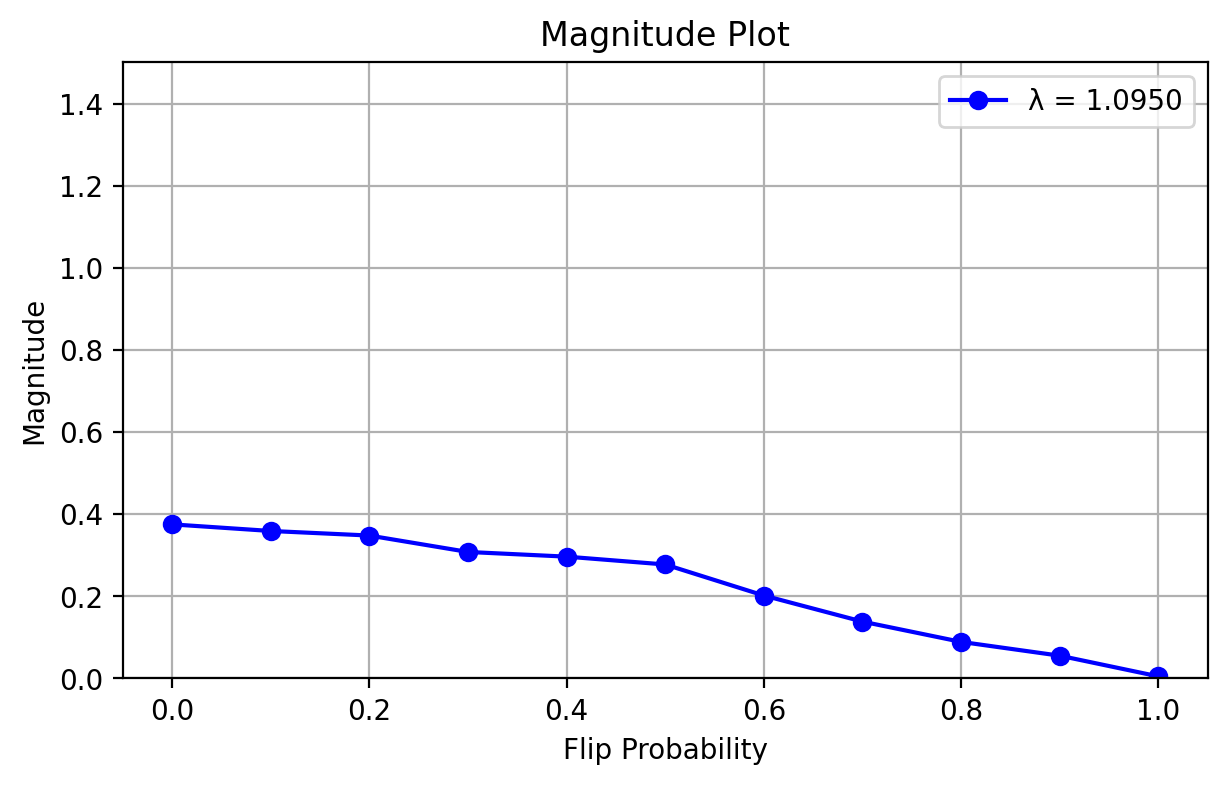

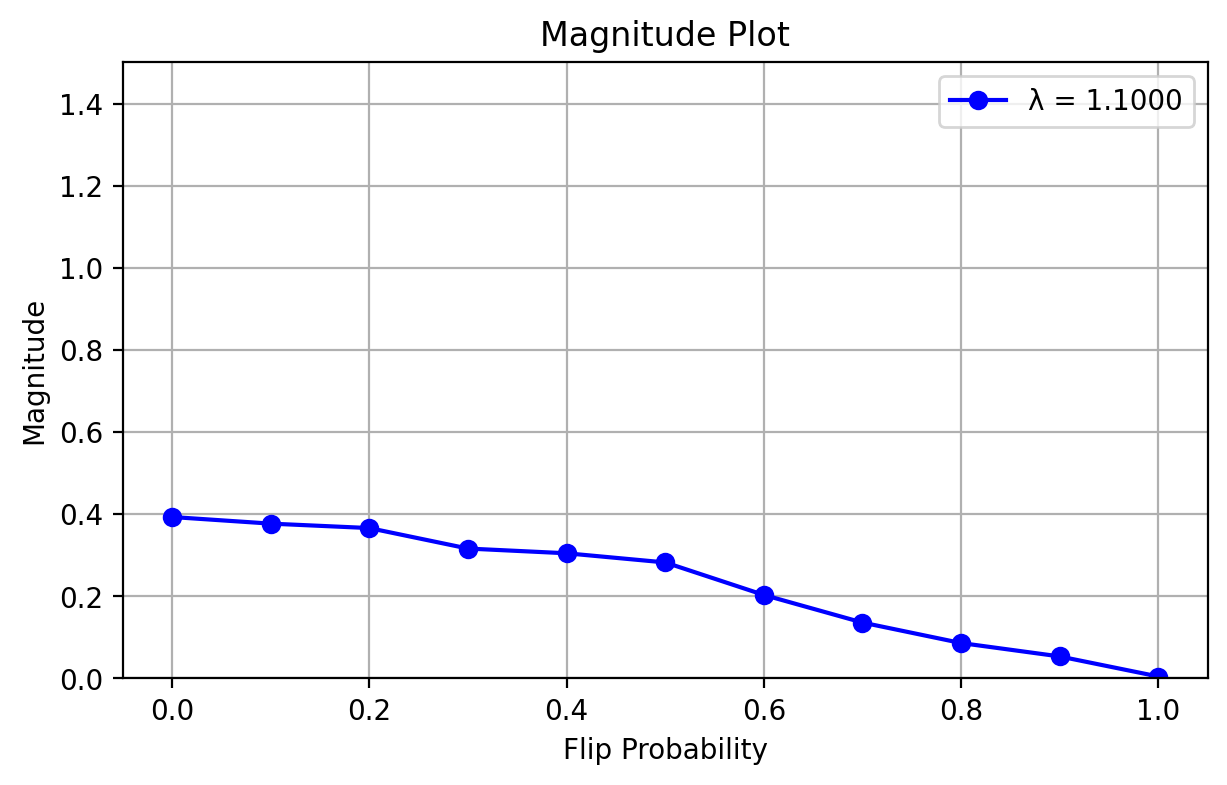

In [4]:
np.random.seed(0)  # Set seed for reproducibility
flip_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Probability of flipping each value   0, 0.1 0.2 ... 1
disc_factor = 0.5
#lmd = -0.5
lmds = np.linspace(1.0,1.1,21)
for lmd in tqdm(lmds):
    magnitude_list = []

    for flip in flip_prob:
        X, Y, Y_sen = generate_synthetic_data(False, n_samples=2000, disc_factor=disc_factor)    #n_samples are per gaussian distributions, we have two hence total_n = 2*n_samples

        Y_corrupted = add_bin_noise(Y, flip)
        Y_sen_corrupted = add_bin_noise(Y_sen, flip)

        #Devide Set into training and test set
        split_index = int(0.7 * len(X))

        # Split the points into training and testing sets (80/20)
        X_train, X_test = X[:split_index], X[split_index:]
        Y_train, Y_test = Y[:split_index], Y[split_index:]
        Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]
        Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
        Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]


        p_reg, p_reg_cor, f_reg, f_reg_cor = LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()
        p_reg.fit(X_train, Y_train)
        p_reg_cor.fit(X_train, Y_corr_train)
        f_reg.fit(X_train, Y_sen_train)
        f_reg_cor.fit(X_train, Y_sen_corr_train)


        
        BER_list = []
        MD_list = []
        DI_list = []

        BER_list_corr = []
        MD_list_corr = []
        DI_list_corr = []

        # Cost sensitivity of classes
        c, c_bar = 0.5, 0.5


        s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        # Apply step function H_a(z) with a = 0
        Y_pred = np.where(s > 0, 1, 0)


        BER = calc_BER(Y_pred, Y_test)
        MD = calc_MD(Y_pred, Y_sen_test, True)
        DI = calc_DI(Y_pred, Y_sen_test, True)
        BER_list.append(BER)
        MD_list.append(MD)
        DI_list.append(DI)

        s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        # Apply step function H_a(z) with a = 0
        Y_pred = np.where(s > 0, 1, 0)


        BER = calc_BER(Y_pred, Y_corr_test)
        MD = calc_MD(Y_pred, Y_sen_corr_test, False)
        DI = calc_DI(Y_pred, Y_sen_corr_test, False)

        BER_list_corr.append(BER)
        MD_list_corr.append(MD)
        DI_list_corr.append(DI)
        
        # Calculate Magnitude of Corruption
        p = np.array([BER_list[0], MD_list[0]])
        p_corr = np.array([BER_list_corr[0], MD_list_corr[0]])
        vector = p_corr - p

        # Calculate the magnitude of the vector
        magnitude = round(np.linalg.norm(vector),4)
        magnitude_list.append((flip, magnitude))

    plt.figure(figsize=(7,4))
    x,y = zip(*magnitude_list)
    plt.plot(x,y, marker='o', color='b',  label=f"λ = {lmd:.4f}")


    # Add labels and title
    plt.xlabel("Flip Probability")
    plt.ylabel("Magnitude")
    plt.title("Magnitude Plot")
    plt.ylim(0,1.5)
    plt.legend()
    # Show grid
    plt.grid(True)
    plt.savefig(f"../img/E1_Label_Noise_for_Single_Points_Magnitude/Lambda_Effect_on_Corruption_lmd_{lmd:.4f}.png")